# Library & data

In [30]:
#!pip install wordcloud

In [12]:
import requests, zipfile, io, os, json, re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

plt.rcParams['font.family'] = 'AppleGothic' 
plt.rcParams['axes.unicode_minus'] = False  

import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터 한 번 다운 받았으면 주석처리

# url = "https://github.com/tunib-ai/DKTC/archive/refs/heads/main.zip"

# print("데이터 다운로드 중...")
# response = requests.get(url)
# if response.status_code == 200:
#     print("다운로드 완료, 압축 해제 중...")
#     with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#         for file in z.namelist():
#             # data/ 폴더 안 파일만 추출
#             if file.startswith("DKTC-main/data/") and not file.endswith('/'):
#                 # 파일 경로 재설정: 'DKTC-main/data/파일명' -> 'data/파일명'
#                 target_path = os.path.join("data", os.path.relpath(file, "DKTC-main/data"))
#                 os.makedirs(os.path.dirname(target_path), exist_ok=True)
#                 with z.open(file) as source, open(target_path, "wb") as target:
#                     target.write(source.read())
#     print("data/ 폴더 추출 완료!")
# else:
#     print("다운로드 실패:", response.status_code)


데이터 다운로드 중...
다운로드 완료, 압축 해제 중...
data/ 폴더 추출 완료!


In [4]:
url = 'data/'

train = pd.read_csv(url+'train.csv')

a = pd.read_csv(url+'general_dialog.csv').rename(columns={'dialogue': 'conversation'})
a['class'] = '일반 대화'
a['idx'] = range(0,len(a))
a = a[['idx','class','conversation']]

train = pd.concat([train, a], axis=0,ignore_index=True).drop(columns='idx')
train.head()

class                                       conversation
0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...

In [5]:
with open(url+"test.json", "r", encoding="utf-8") as f:
    test = pd.DataFrame({"conversation": [v["text"] for v in json.load(f).values()]})

test.head()

conversation
0  아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1  우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? ...
2  너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3  이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4  아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...

# EDA

In [7]:
train['class'].value_counts()

class
기타 괴롭힘 대화      1094
일반 대화          1000
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: count, dtype: int64

## 단순 글자 수로 문장길이

In [13]:
train['length'] = train['conversation'].apply(len)

classes = sorted(train['class'].unique())

plt.figure(figsize=(12, 20)) 
plt.suptitle('Class 별 문장(단순글자수) 길이', fontsize=16)

for i, cls in enumerate(classes):
    print(f"{i} : {cls}")
    subset = train[train['class'] == cls]['length']
    desc = subset.describe()
    
    # --- Boxplot (윗줄) ---
    plt.subplot(5, 2, 2*i + 1) 
    plt.boxplot(subset, vert=True, patch_artist=True)
    plt.title(f'Class: {i} - Boxplot') 
    plt.ylabel('Length')

    # --- Histogram (아랫줄) ---
    plt.subplot(5, 2, 2*i + 2) 
    plt.hist(subset, bins=40, alpha=0.7)
    plt.title(f'Class: {cls} - Histogram') 
    plt.xlabel('Sample 개수')
    plt.ylabel('Length')
    
    # --- describe() 통계치를 우상단에 텍스트로 추가 ---
    stats_text = f"count: {desc['count']:.0f}\nmean: {desc['mean']:.2f}\nstd: {desc['std']:.2f}\nmin: {desc['min']:.0f}\n25%: {desc['25%']:.0f}\n50%: {desc['50%']:.0f}\n75%: {desc['75%']:.0f}\nmax: {desc['max']:.0f}"
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


0 : 갈취 대화
1 : 기타 괴롭힘 대화
2 : 일반 대화
3 : 직장 내 괴롭힘 대화
4 : 협박 대화


## 띄어쓰기 기준 Token 수로 문장길이

0 : 갈취 대화
1 : 기타 괴롭힘 대화
2 : 일반 대화
3 : 직장 내 괴롭힘 대화
4 : 협박 대화


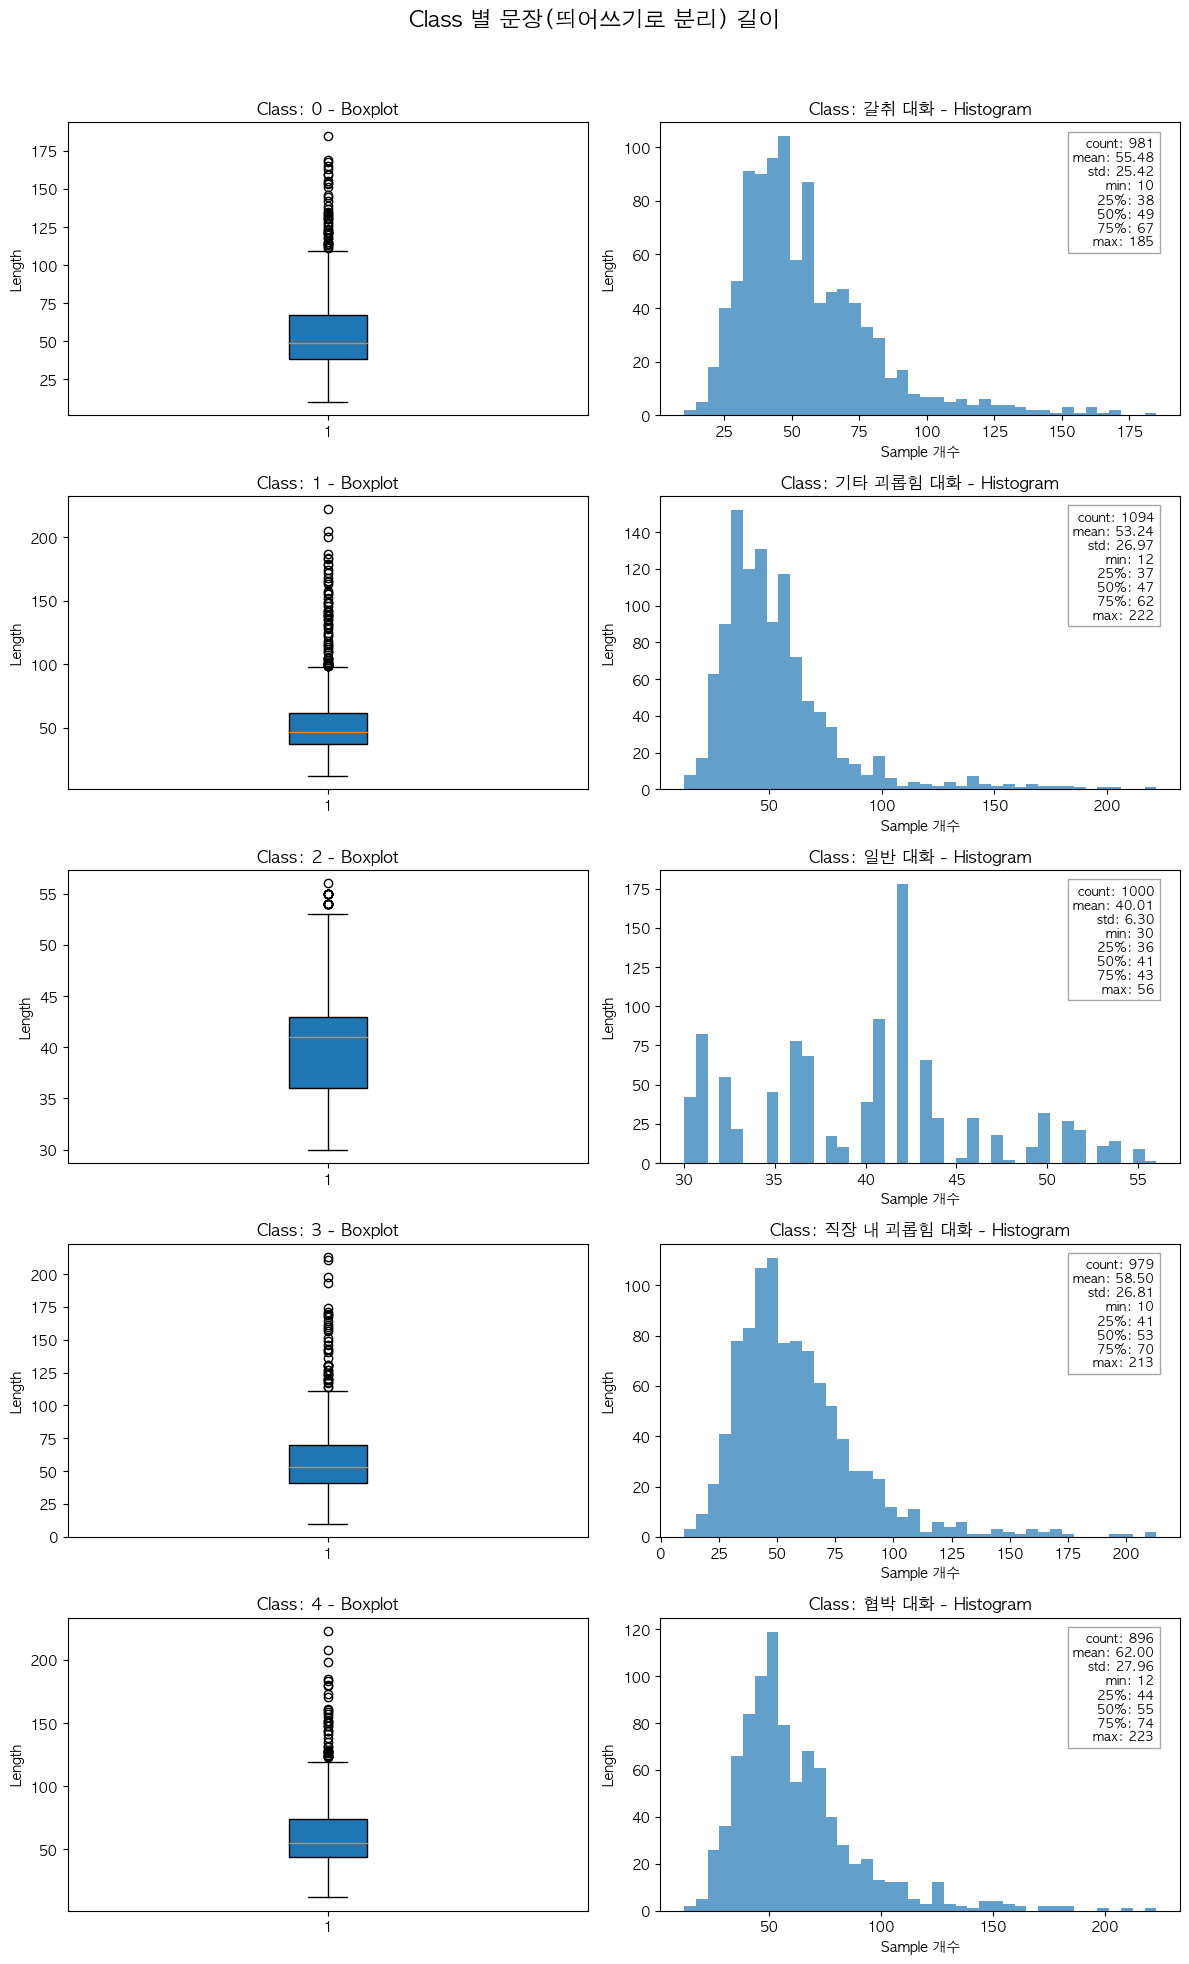

In [14]:
train['text_len'] = train['conversation'].apply(lambda s: len(s.split()))

classes = sorted(train['class'].unique())

plt.figure(figsize=(12, 20)) 
plt.suptitle('Class 별 문장(띄어쓰기로 분리) 길이', fontsize=16)

for i, cls in enumerate(classes):
    print(f"{i} : {cls}")
    subset = train[train['class'] == cls]['text_len']
    desc = subset.describe()
    
    # --- Boxplot (윗줄) ---
    plt.subplot(5, 2, 2*i + 1) 
    plt.boxplot(subset, vert=True, patch_artist=True)
    plt.title(f'Class: {i} - Boxplot') 
    plt.ylabel('Length')

    # --- Histogram (아랫줄) ---
    plt.subplot(5, 2, 2*i + 2) 
    plt.hist(subset, bins=40, alpha=0.7)
    plt.title(f'Class: {cls} - Histogram') 
    plt.xlabel('Sample 개수')
    plt.ylabel('Length')
    
    # --- describe() 통계치를 우상단에 텍스트로 추가 ---
    stats_text = f"count: {desc['count']:.0f}\nmean: {desc['mean']:.2f}\nstd: {desc['std']:.2f}\nmin: {desc['min']:.0f}\n25%: {desc['25%']:.0f}\n50%: {desc['50%']:.0f}\n75%: {desc['75%']:.0f}\nmax: {desc['max']:.0f}"
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top', horizontalalignment='right',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Stopword 없이 class별 주요 단어 확인

In [20]:
okt = Okt()

def extract_nouns(text):
    nouns = okt.nouns(text)
    return [noun for noun in nouns if len(noun) > 1]


# 불용어를 제거하며 명사를 추출하는 함수로 업그레이드
def extract_nouns_with_stopwords(text):
    nouns = okt.nouns(text)
    return [noun for noun in nouns if len(noun) > 1]


# 모든 대화(conversation)에 대해 토큰화 수행
train['tokens_1'] = train['conversation'].apply(extract_nouns_with_stopwords)

In [21]:
# 'tokens' 컬럼의 모든 리스트를 하나의 큰 리스트로 합치기
all_tokens_1 = np.hstack(train['tokens_1'].values)
token_counts_1 = Counter(all_tokens_1)

# 가장 많이 등장한 단어 50개 출력
print("--- [가장 많이 등장한 주요 단어 (Top 50)] ---")
print(token_counts_1.most_common(50))

# 빈도수 상위 20개 단어 시각화
top_n = 20
top_tokens_1 = token_counts_1.most_common(top_n)
top_df_1 = pd.DataFrame(top_tokens_1, columns=['Token', 'Frequency'])

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Frequency', y='Token', data=top_df_1, palette='viridis')
plt.title(f'주요 단어 빈도 (Top {top_n})')

# 각 막대 끝에 빈도수 표시
for i, (freq) in enumerate(top_df_1['Frequency']):
    ax.text(freq + 1, i, str(freq), va='center')

plt.show()

--- [가장 많이 등장한 주요 단어 (Top 50)] ---
[('진짜', 1476), ('지금', 1387), ('사람', 1381), ('우리', 1173), ('생각', 1054), ('오늘', 1022), ('그냥', 988), ('무슨', 931), ('제발', 900), ('내일', 751), ('시간', 745), ('조금', 711), ('여기', 698), ('이번', 646), ('새끼', 640), ('하나', 610), ('정말', 586), ('잠깐', 552), ('회의', 543), ('회사', 532), ('그게', 516), ('친구', 491), ('사진', 477), ('대리', 476), ('한번', 473), ('엄마', 467), ('다음', 457), ('마음', 428), ('소리', 400), ('이제', 399), ('그거', 384), ('어디', 380), ('이야기', 369), ('신고', 361), ('다시', 361), ('자리', 345), ('말씀', 344), ('당장', 342), ('자네', 329), ('부장', 329), ('당신', 328), ('보고', 300), ('저기', 292), ('포인트', 287), ('다른', 286), ('변경', 284), ('요즘', 275), ('나중', 273), ('정도', 270), ('참고', 268)]


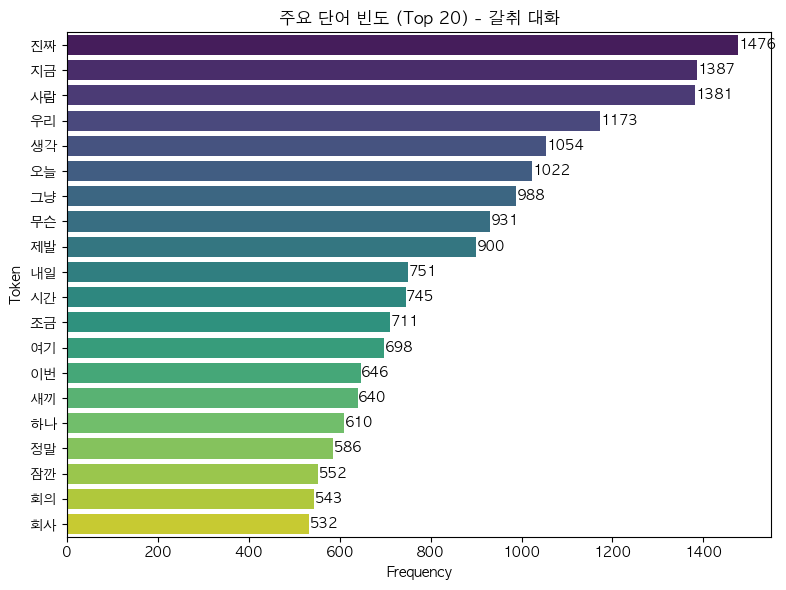

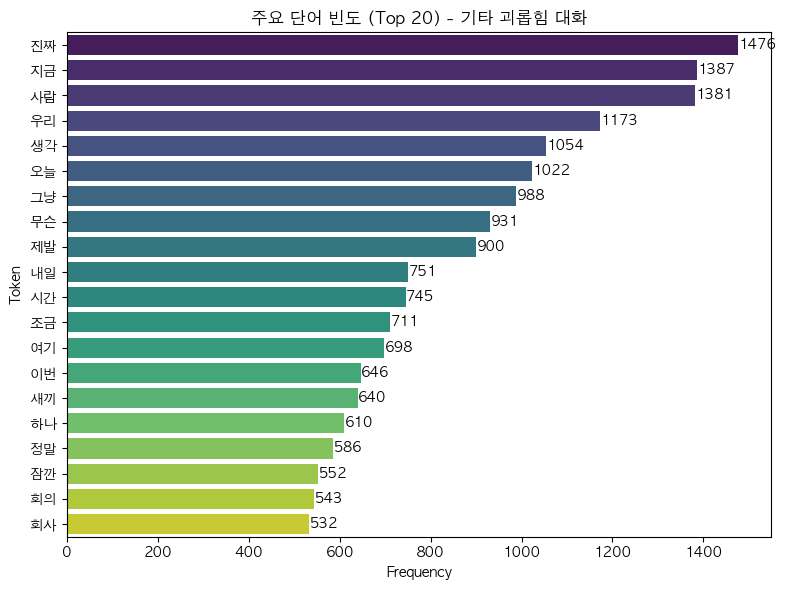

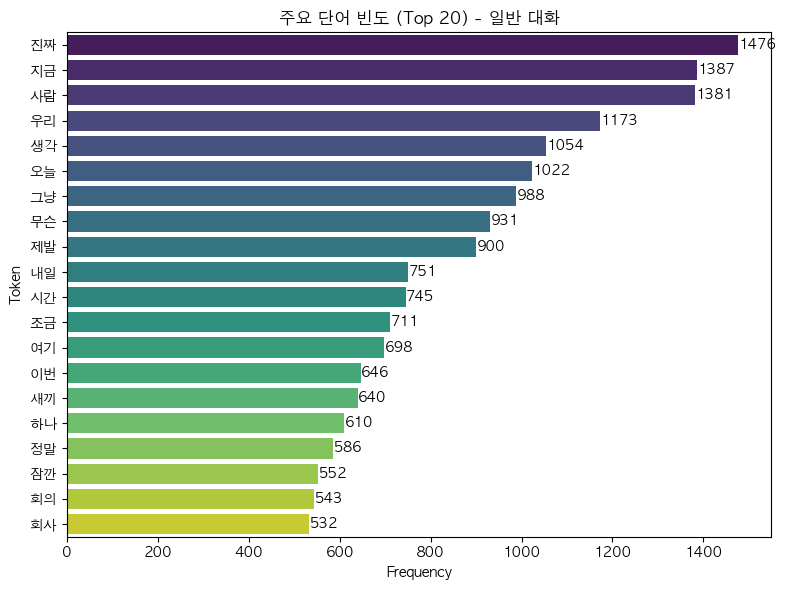

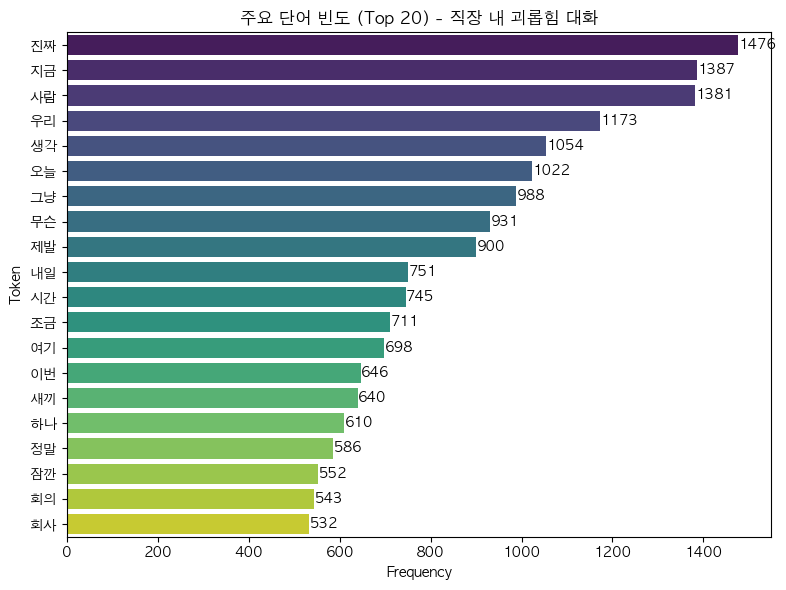

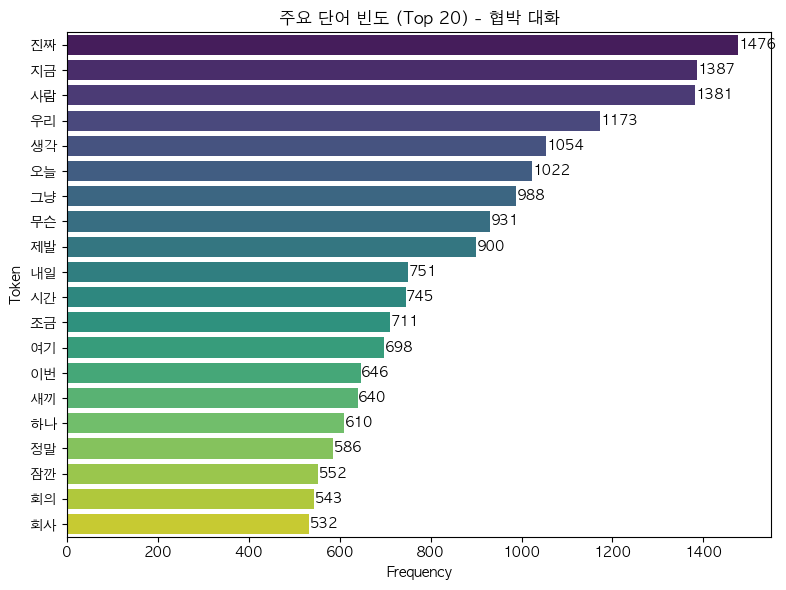

In [22]:
all_tokens_grouped_1 = train.groupby('class')['tokens_1'].apply(np.hstack)

top_n = 20

for class_name, tokens in all_tokens_grouped_1.items():
    counts = Counter(tokens)
    top_words = counts.most_common(top_n)
    
    top_df = pd.DataFrame(top_words, columns=['Token', 'Frequency'])
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Frequency', y='Token', data=top_df_1, palette='viridis')
    plt.title(f'주요 단어 빈도 (Top {top_n}) - {class_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    
    # 각 막대 끝에 빈도수 표시
    for i, freq in enumerate(top_df_1['Frequency']):
        ax.text(freq + 1, i, str(freq), va='center')
    
    plt.tight_layout()
    plt.show()


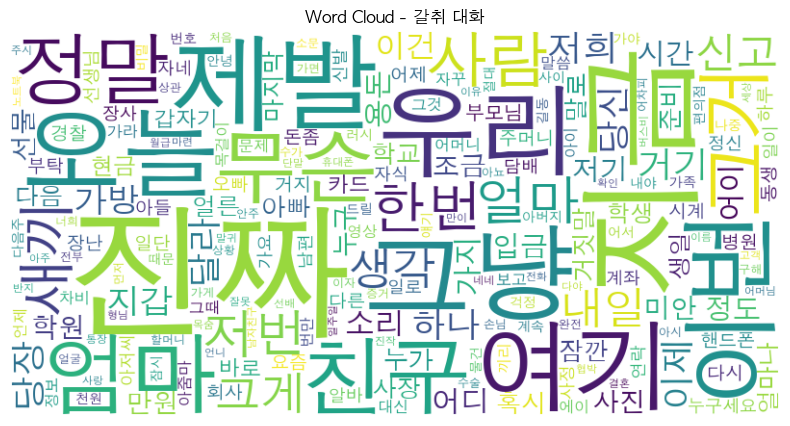

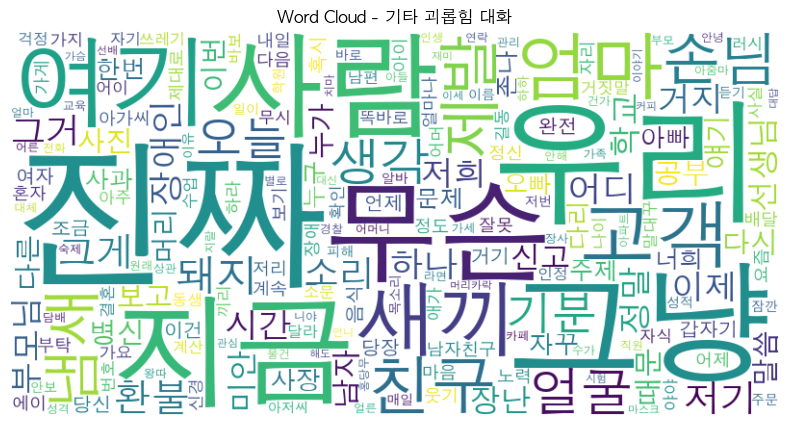

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 예: 클래스별 워드클라우드
for class_name, tokens in all_tokens_grouped_1.items():
    counts = Counter(tokens)
    
    wordcloud = WordCloud(
        font_path="/System/Library/Fonts/Supplemental/AppleGothic.ttf",  # 여기 반드시 지정
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(counts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {class_name}')
    plt.show()


## Stopword 사용해서 class별 주요 단어 확인

In [24]:
okt = Okt()

def extract_nouns(text):
    nouns = okt.nouns(text)
    return [noun for noun in nouns if len(noun) > 1]

korean_stopwords = [
    '이', '그', '저', '것', '수', '등', '때', '곳', '나', '너', '우리', '경우', 
    '사람', '일', '지금', '생각', '말', '안', '뭐', '정말', '왜', '오늘', '내일',
    '여기', '거기', '이제', '먼저', '하나', '무슨', '위해', '때문', '정도', 
    '그냥', '진짜', '너무', '완전', '혹시', '계속', '아니', '알', '더', '좀'
]

# 불용어를 제거하며 명사를 추출하는 함수로 업그레이드
def extract_nouns_with_stopwords(text):
    nouns = okt.nouns(text)
    return [noun for noun in nouns if len(noun) > 1 and noun not in korean_stopwords]


# 모든 대화(conversation)에 대해 토큰화 수행
train['tokens_2'] = train['conversation'].apply(extract_nouns_with_stopwords)

--- [가장 많이 등장한 주요 단어 (Top 50)] ---
[('제발', 900), ('시간', 745), ('조금', 711), ('이번', 646), ('새끼', 640), ('잠깐', 552), ('회의', 543), ('회사', 532), ('그게', 516), ('친구', 491), ('사진', 477), ('대리', 476), ('한번', 473), ('엄마', 467), ('다음', 457), ('마음', 428), ('소리', 400), ('그거', 384), ('어디', 380), ('이야기', 369), ('신고', 361), ('다시', 361), ('자리', 345), ('말씀', 344), ('당장', 342), ('자네', 329), ('부장', 329), ('당신', 328), ('보고', 300), ('저기', 292), ('포인트', 287), ('다른', 286), ('변경', 284), ('요즘', 275), ('나중', 273), ('참고', 268), ('저희', 264), ('검토', 263), ('초안', 263), ('부탁', 262), ('위주', 261), ('어제', 258), ('가독성', 256), ('정확성', 256), ('히스토리', 256), ('이력', 256), ('어가', 256), ('얼굴', 254), ('누가', 252), ('가족', 250)]


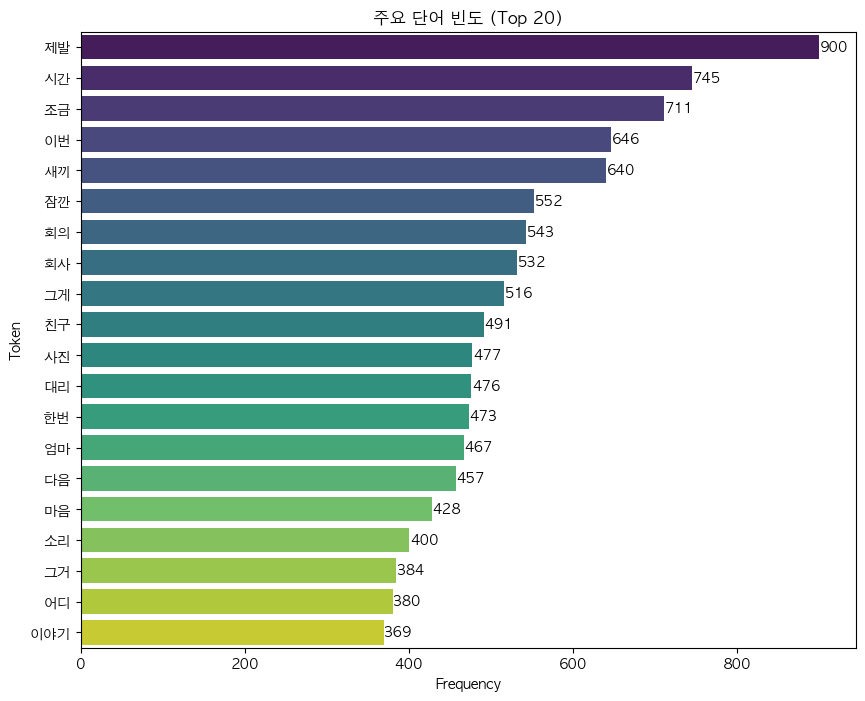

In [25]:
# 'tokens' 컬럼의 모든 리스트를 하나의 큰 리스트로 합치기
all_tokens_2 = np.hstack(train['tokens_2'].values)
token_counts_2 = Counter(all_tokens_2)

# 가장 많이 등장한 단어 50개 출력
print("--- [가장 많이 등장한 주요 단어 (Top 50)] ---")
print(token_counts_2.most_common(50))

# 빈도수 상위 20개 단어 시각화
top_n = 20
top_tokens_2 = token_counts_2.most_common(top_n)
top_df_2 = pd.DataFrame(top_tokens_2, columns=['Token', 'Frequency'])

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='Frequency', y='Token', data=top_df_2, palette='viridis')
plt.title(f'주요 단어 빈도 (Top {top_n})')

# 각 막대 끝에 빈도수 표시
for i, (freq) in enumerate(top_df_2['Frequency']):
    ax.text(freq + 1, i, str(freq), va='center')

plt.show()

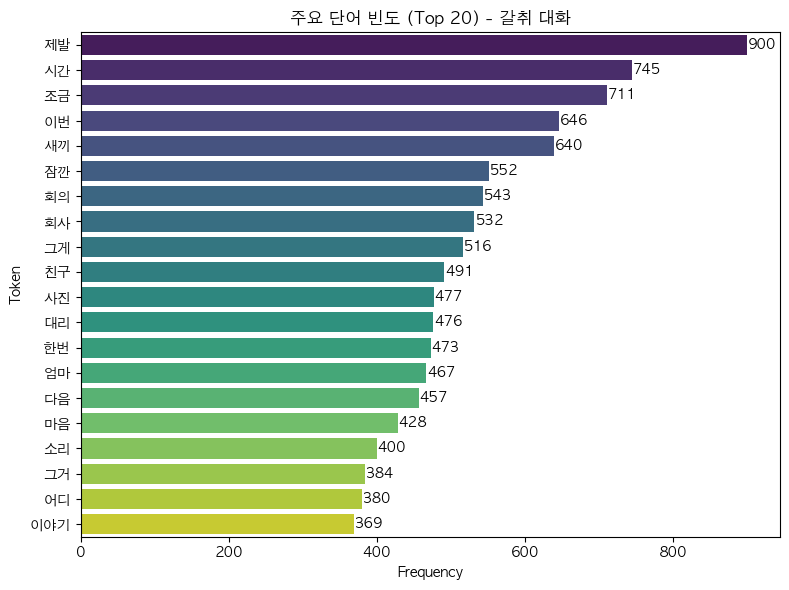

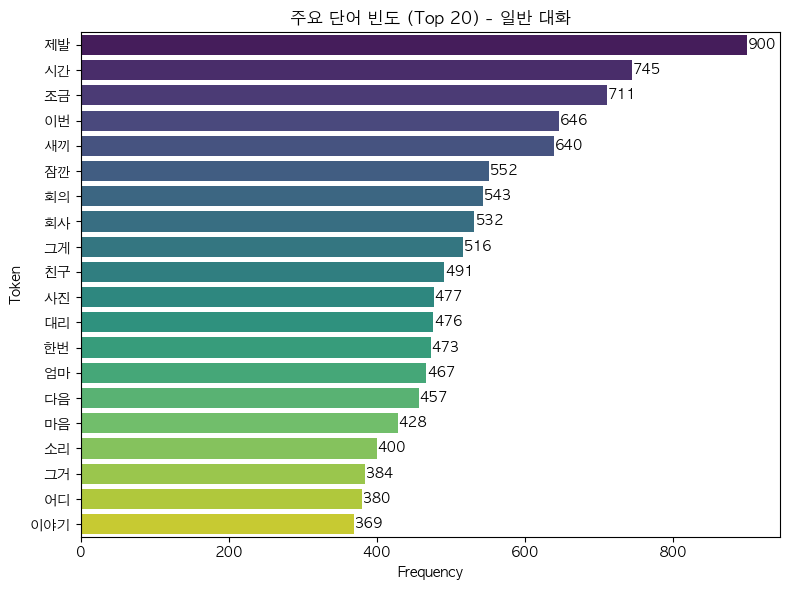

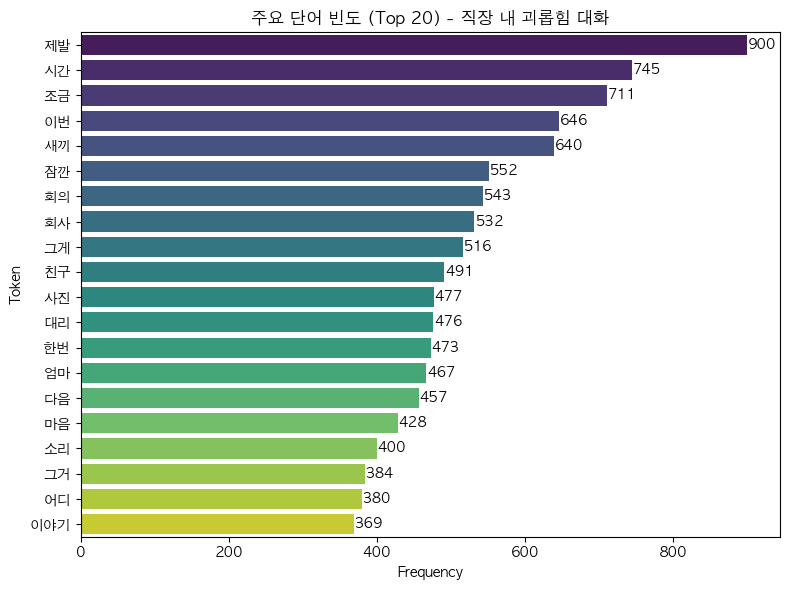

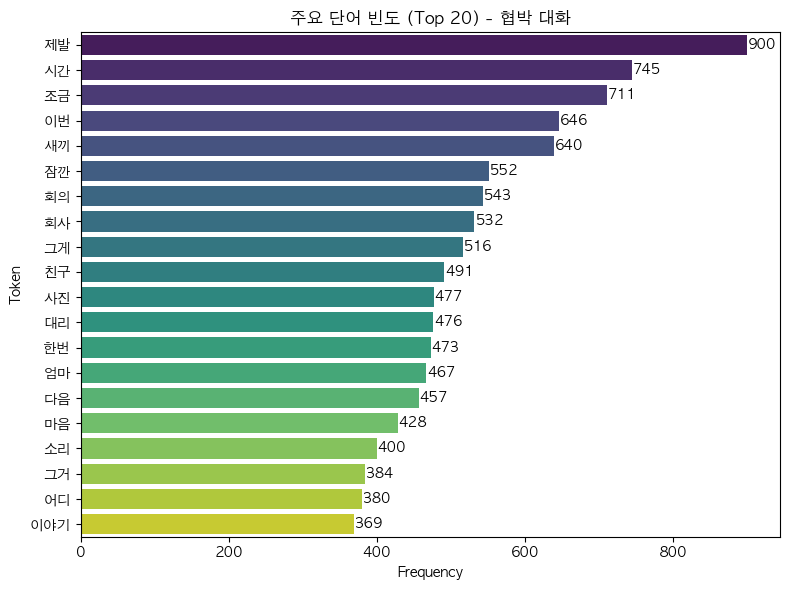

In [28]:
all_tokens_grouped_2 = train.groupby('class')['tokens_2'].apply(np.hstack)


top_n = 20

for class_name, tokens in all_tokens_grouped_2.items():
    counts = Counter(tokens)
    top_words = counts.most_common(top_n)
    
    top_df = pd.DataFrame(top_words, columns=['Token', 'Frequency'])
    
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x='Frequency', y='Token', data=top_df_2, palette='viridis')
    plt.title(f'주요 단어 빈도 (Top {top_n}) - {class_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Token')
    
    # 각 막대 끝에 빈도수 표시
    for i, freq in enumerate(top_df_2['Frequency']):
        ax.text(freq + 1, i, str(freq), va='center')
    
    plt.tight_layout()
    plt.show()


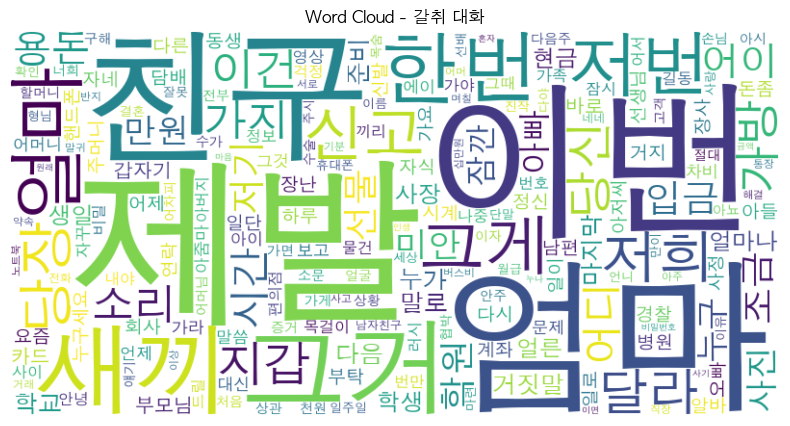

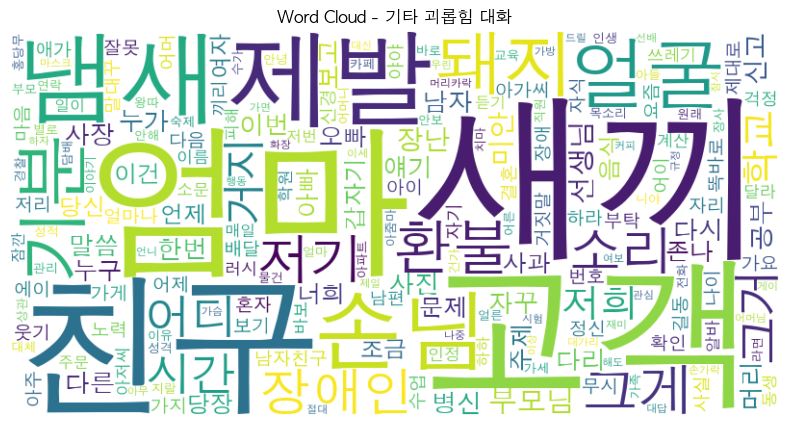

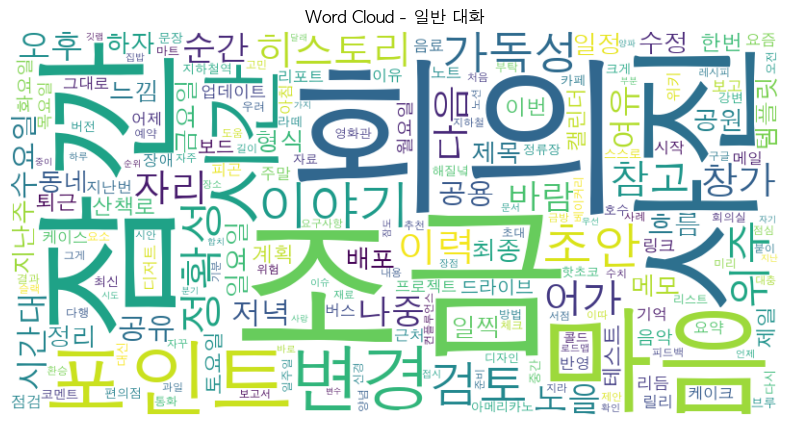

In [29]:
for class_name, tokens in all_tokens_grouped_2.items():
    counts = Counter(tokens)
    
    wordcloud = WordCloud(
        font_path="/System/Library/Fonts/Supplemental/AppleGothic.ttf",  # 여기 반드시 지정
        width=800,
        height=400,
        background_color='white'
    ).generate_from_frequencies(counts)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {class_name}')
    plt.show()


# Preprocessing